(hgf_exercises)=
# An introduction to Hierarchical Gaussian Filters through practical exercises

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Exercise_1_Using_the_HGF.ipynb)

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install phygf watermark

In [2]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from pytensor import function, scan

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF
from pyhgf.response import binary_softmax, first_level_gaussian_surprise

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
# load an example time series for continuous inputs
timeseries = load_data("continuous")

In this tutorial, we introduce the continuous and binary Hierarchical Gaussian Filters and describe their application in computational psychiatry research.

We start by reviewing the core principles on which the HGF is built: a generative model of embedded stochastic processes to describe hidden states of the world. In the first part, we review the mathematical description of such operations and how to implement them in Python.

In the second part, we apply this model to real-world data (weather dataset) by creating an agent that *uses* this model to filter sensory information and update internal beliefs about hidden states of the world. We then try to apply Bayesian inference over some of the agent's parameters.

In the third part, we introduce the binary Hierarchical Gaussian filter and consider experimental designs familiar in reinforcement learning, where the agent tries to learn the association between stimuli, or the occurrence of binary events. Then again,- we apply Bayesian inference and try to compare the performance of our model with alternative explanations of an agent's behaviours.

## Belief updating under uncertainty: the continuous Hierarchical Gaussian Filter
### Gaussian random walks

Hierarchical Gaussian Filters are built on a generalisation of the [Gaussian Random Walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) (GRW). A GRW is a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) that generate a new observation $x_1^{(k)}$ at each time step $k$ from a normal distribution and using the previous observation $x_1^{(k-1)}$ as its mean such as:

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \sigma^2)
$$

where $\sigma^2$ is the fixed variance of the distribution. 

```{admonition} Exercise 1
Using the equation above, write a Python code that implements a Gaussian random walk using the following parameters: $\sigma^2 = 1$ and $x_1^{(0)} = 0$.
```

### Value and volatility coupling between probabilistic nodes

We have simulated above a simple GRW. At each time point, this process is fully described by the probability distribution and the sufficient statistics of this probability distribution (the mean and the variance). Using these values, we can also derive expected values (using the current mean) and expected precision (using the current variance).

The HGF hierarchically generalize this process by making the parameters of a stochastic process depend on another GRW at a different level. In [PyHGF](https://github.com/ilabcode/pyhgf) we use a *nodalized* version of this framework {cite:p}`weber:2023`, and consider that each stochastic process is a node in a network, connected with other nodes through probabilistic dependencies: **value coupling** (targetting the value $\mu$ of the child node) or **volatility coupling** (targetting the volatility $\sigma^2$ of the child node).

Let's consider for example a network constituted of two nodes $x_1$ and $x_2$, as it is found in the continuous HGF {cite:p}`2014:mathys`. The node $x_1$ is performing a GRW as previously described. We can add a dependency on the mean of the distribution (**value coupling**) by assuming that $x_1$ inherits the difference step from $x_2$, instead of using only its own previous value. Mathematically, this would write:

$$
x_2^{(k)} \sim \mathcal{N}(x_2^{(k-1)}, \, \sigma_2^2) \\
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)} + \alpha_{1} x_2^{(k)}, \, \sigma_1^2) \\
$$

Note that this generative process reads top-down: the node higher in the hierarchy ($x_2$) generates new values and passes them to the child nodes.

We can also arrange things differently, for example assuming  that $x_1$ runs the GRW as usual, but this time it is paired with $x_2$ via **volatility coupling**. This means that for state $x_1$, the mean of the Gaussian random walk on time point $k$ is given by its previous value $x_1^{(k-1)}$, while the step size (or variance) depends on the current value of the higher level state, $x_2^{(k)}$.

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \, f(x_2^{(k)}))
$$

where the exact dependency is of the form

$$
    f(x_2^{(k)}) = \exp(x_2^{(k)} + \omega_1)
$$

At the higher level of the hierarchy (here the second level), the nodes are not inheriting anything from their parents anymore, and only rely on their own variance:

$$
x_2^{(k)} \sim \mathcal{N}(x_2^{(k-1)}, \, \exp(\omega_2))
$$

```{hint}
Here the volatility is not simply inherited from the higher node, it is mixed with another quantity ($\omega_2$). This is because we don't want the parent node to explain all the variance alone, the child node ($x_1$) also has a parameter for its own variance and expects some variability by itself. The parent node can weigh on this by adding or removing variance in the final quantity. $\omega$ is sometimes refered to as the *tonic* part of the variance, or the *evolution rate*, while $x_2$ is the *phasic* part of the variance.
```

```{admonition} Exercise 2
- Using the equation above and your previous implementation, write a Python code that implements a hierarchical Gaussian random walk with the following parameters: $\omega_1 = -6.0$, $\omega_2 = -6.0$, $\mu_1 = 0.0$, $\mu_2 = -2.0$, $x_{1} = 0.0$ and $x_{2} = -2.0$

- What happens when we change the values of $\omega_1$?

- What happens when we change the values of $\omega_2$?
```

### The continuous Hierarchical Gaussian Filter

Hierarchical Filters are built on the notion that we can embed stochastic nodes and make them depend on each other and use this as a generative model of hidden states of the world.

We therefore want to create agents that can use this principle to filter the sensory inputs they receive. But this time we have to think the other way. We do not want to generate data top-down (as in the function you wrote above), we already have the data in the form of sensory inputs. We want to provide this sensory input to the model and update the probabilistic nodes accordingly so that they continue to predict the next sensory input reasonably well.

This requires propagating updates on sufficient statistics and sending precision-weighted prediction errors to the parent nodes. The pyhgf package implements this process with the corresponding update equation so the model can take as input a time series and infer the more likely generative structure that created the values. This can be extremely useful if you want to work with time series that have varying levels of volatility (i.e. meta-volatility). In the following example, we illustrate how we can use the Hierarchical Gaussian Filter to filter and predict inputs in a continuous node.

In [4]:
# create a two-levels continuous HGF
two_levels_continuous_hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mean={"1": 1.04, "2": 0.0},
    initial_precision={"1": 1e4, "2": 1.0},
    tonic_volatility={"1": -6.0, "2": -2.0},
)

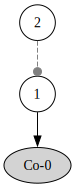

In [5]:
# plot the implied probabilistic network
two_levels_continuous_hgf.plot_network()

In [6]:
# add new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=timeseries)

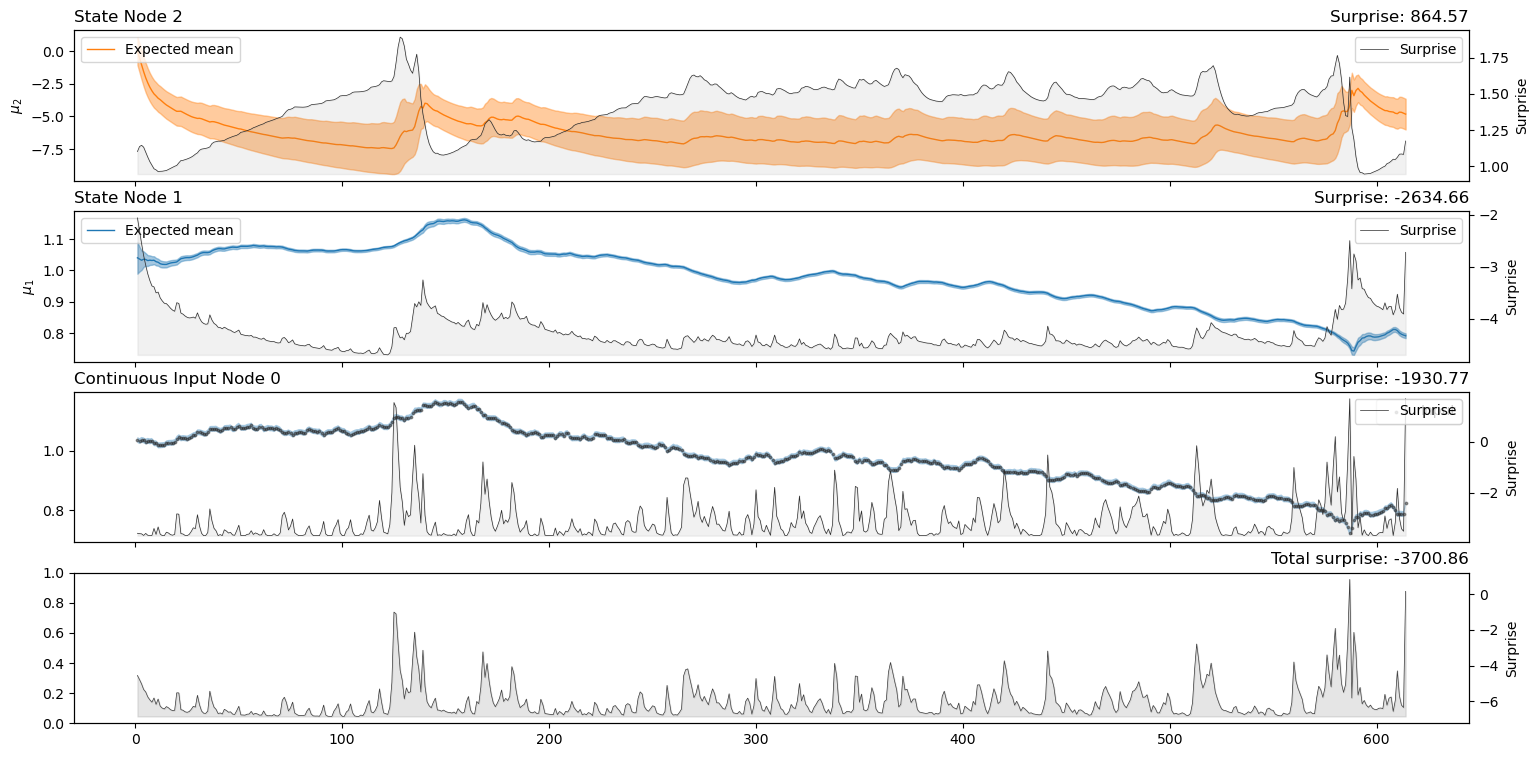

In [7]:
# plot the trajectories of the model beliefs
two_levels_continuous_hgf.plot_trajectories();

In [8]:
# return the sum of surprise at the input node
two_levels_continuous_hgf.surprise()

Array(-1100.1322, dtype=float32)

| parameter | description |
| --- | --- |
| $\mu_i$ | The mean of the distribution in node $i$. |
| $\pi_i$ | The precision of the distribution in node $i$. the precision is the inverse of the variance ($\frac{1}{\sigma^2}$) |
| $\omega_i$ | The evolution rate, or the tonic part of the variance of the distribution in node $i$. |

```{admonition} Exercise 3
$\omega$ represents the tonic part of the variance (the part that is not affected by the parent node). Using the code example above, create another model with different values for $\omega$ at the second level. What is the consequence of changing this value on the belief trajectories? What is the "best" model in this context?
```

### Parameters optimization

So far we have been running the HGF forward by fixing the values of the parameters beforehand. This is an important part of the modelling process as we can retrieve the belief trajectories, which indicates how the agent might use sensory information to adapt to the environment, as well as the surprise associated with these observations, which indicates *how well* the agent adapted to the environment. 

In the context of analysing data from a task, we do not want to fit the data manually and retrieve the trajectories from every possible set of parameters. Instead, we want to perform Bayesian inference over these parameters and estimate the posterior of the probability distribution. Here we are going to perform this step using Hamiltonian Monte Carlo sampling as implemented in PyMC.

In [9]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    input_data=timeseries[jnp.newaxis, :],
    response_function=first_level_gaussian_surprise
)

In [10]:
with pm.Model() as two_level_hgf:

    # tonic volatility priors
    tonic_volatility_1 = pm.Uniform("tonic_volatility_1", -20, -2.0)

    # HGF distribution
    pm.Potential("hgf_loglike", hgf_logp_op(
        tonic_volatility_1=tonic_volatility_1, 
        tonic_volatility_2=-2.0, mean_1=1.0
    )
                )

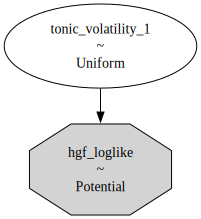

In [11]:
pm.model_to_graphviz(two_level_hgf)

In [12]:
with two_level_hgf:
    idata = pm.sample(chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [tonic_volatility_1]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


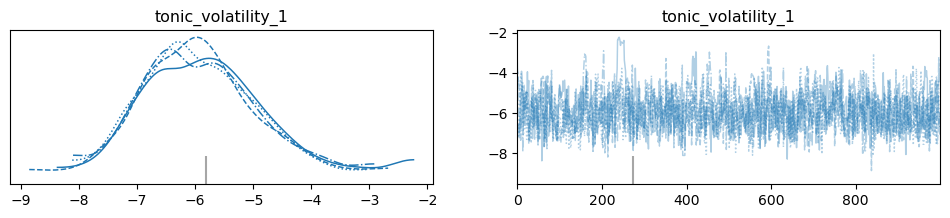

In [13]:
az.plot_trace(idata);

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tonic_volatility_1,-5.934,0.933,-7.521,-4.16,0.033,0.023,933.0,867.0,1.0


### Practice: Filtering the worlds weather

In the previous section, we introduced the computational concept behind the Hierarchical Gaussian Filter and illustrated:

1. How to create Gaussian Random Walks with hierarchical dependencies.
1. How to fit the HGF to a time series with continuous inputs.
2. How to find the posterior distribution over some parameters given sensory data and a response function.

For the time left before the break, you are going to apply this knowledge to a more practical context: filtering the world's weather. We will use data from {cite:p}`pfenninger:2016, staffell:2016` that is made available at [the following database](https://renewables.ninja/). This database contains hourly recordings of various weather parameters that have been tracked over one year at different positions in the world. The data from Aarhus can be loaded using the following function call:

In [15]:
aarhus_weather_df = pd.read_csv("https://raw.githubusercontent.com/ilabcode/hgf-data/main/datasets/weather.csv")
aarhus_weather_df.head()

,time,t2m,prectotland,precsnoland,snomas,rhoa,swgdn,swtdn,cldtot
0,2019-01-01 00:00,7.387,0.124,0.0,0.0,1.249,0.0,0.0,0.931
1,2019-01-01 01:00,7.472,0.200,0.0,0.0,1.247,0.0,0.0,0.865
2,2019-01-01 02:00,7.635,0.196,0.0,0.0,1.244,0.0,0.0,0.701
3,2019-01-01 03:00,7.224,0.061,0.0,0.0,1.245,0.0,0.0,0.387
4,2019-01-01 04:00,6.147,0.018,0.0,0.0,1.250,0.0,0.0,0.128


The data frame contains the following parameters, recorded every hour over the year of 2019:

| parameter | description |
| --- | --- |
| t2m | The 2-meter above ground level air temperature |
| prectotland | The rain precipitation rate (mm/hour) |
| precsnoland | Snow precipitation rate (mm/hour) |
| snomas | Total snow storage land (kg/m2) |
| rhoa | Air density at surface (kg/m3) |
| swgdn | Surface incoming shortwave flux (W/m2) (considering cloud cover) (The value at the surface is approximately 1000 W/m2 on a clear day at solar noon in the summer months) |
| swtdn | Toa (top of atmosphere) incoming shortwave flux (W/m2) |
| cldtot | Total cloud area fraction. An average over grid cells and summed over all height above ground ([0,1] scale where 0 is no cloud and 1 is very cloudy) |

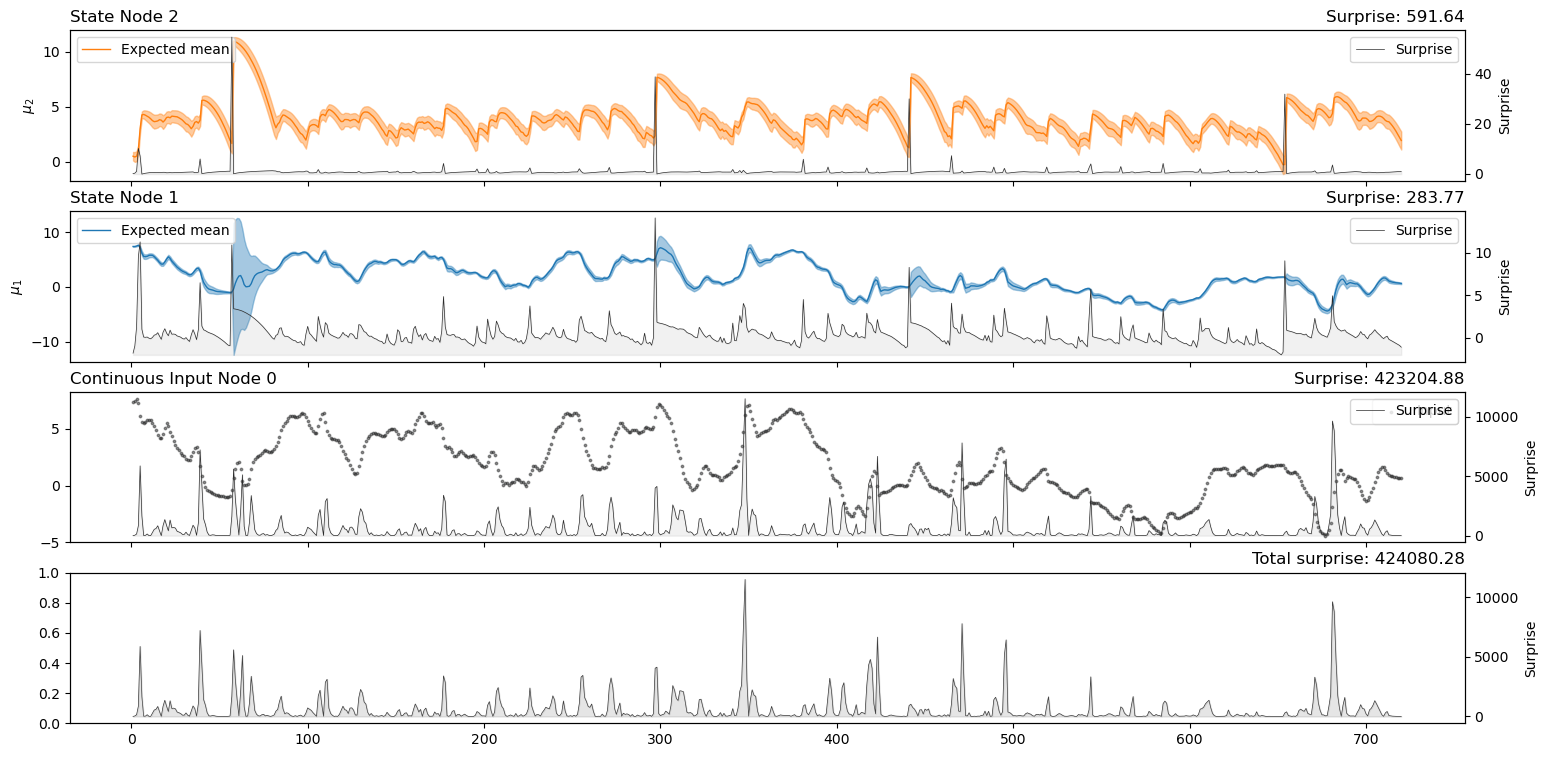

In [16]:
# Load time series example data
timeserie = aarhus_weather_df["t2m"][:24*30].to_numpy()

# This is where we define all the model parameters - You can control the value of
# different variables at different levels using the corresponding dictionary.
hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mean={"1": timeserie[0], "2": .5},
    initial_precision={"1": 1e4, "2": 1e1},
    tonic_volatility={"1":-6.0, "2": -3.0},
)

# add new observations
hgf.input_data(input_data=timeserie)

# visualization of the belief trajectories
hgf.plot_trajectories();

```{admonition} Exercises 4
- Select a city and download a recording OR use the data frame loaded above.
- Fit an agent using one of the variables and compute the posterior probability over this parameter.
```

## Bayesian reinforcement learning: the binary HGF

In the first part of the tutorial, we introduced the continuous Hierarchical Gaussian Filter and detailed how it is built on top of hierarchical GRW. This model is intended to work with continuous input variables. In this regard, it can be seen as a generalization of the Kalman filter. However, several experiments require working with variables that have discrete states.

The binary HGF can be seen as an extension of the continuous HGF, with the exception that it has a binary input node except one a continuous one. Handling such binary variables can be useful, for example for reinforcement learning paradigms where we want the agent to learn the association between two states in the world. Such experiments, like the [one-armed badit task](https://en.wikipedia.org/wiki/Multi-armed_bandit) that we will be using below, generally produce two types of information at each trial:
- the action $y$, as a boolean variable, that is registering the decision made by the agent at time $t$, at the beginning of the trial.
- the observation $u$ about the association between the stimuli and the outcomes, as a boolean (e.g. `1` if Stim_1 -> Outcome_1 and Stim_2 -> Outcome_2, `0` otherwise). 

We can load an example dataset from {cite:p}`Iglesias2021` using the following command that will return a vector of observations $u$ and a vector of decision $y$.

In [17]:
u, y = load_data("binary")

### The binary Hierarchical Gaussian Filter

Fitting data to a binary HGF is quite similar to the continuous one (note that ```model_type="binary"```).

In [18]:
two_levels_hgf = HGF(
    n_levels=2,
    model_type="binary",
    initial_mean={"1": .0, "2": 0.0},
    initial_precision={"1": np.nan, "2": 1.0},
    tonic_volatility={"2": -5},
)

This is a two-level binary HGF, so we have one continuous node predicting the outcomes of a binary state node.

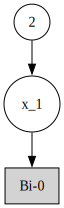

In [19]:
two_levels_hgf.plot_network()

The observations about the associations are provided as input data and will be the sensory information the agent uses to update its beliefs.

In [20]:
two_levels_hgf = two_levels_hgf.input_data(input_data=u)

The node trajectories illustrate how new binary outcomes change the expectations about the associations between the stimuli.

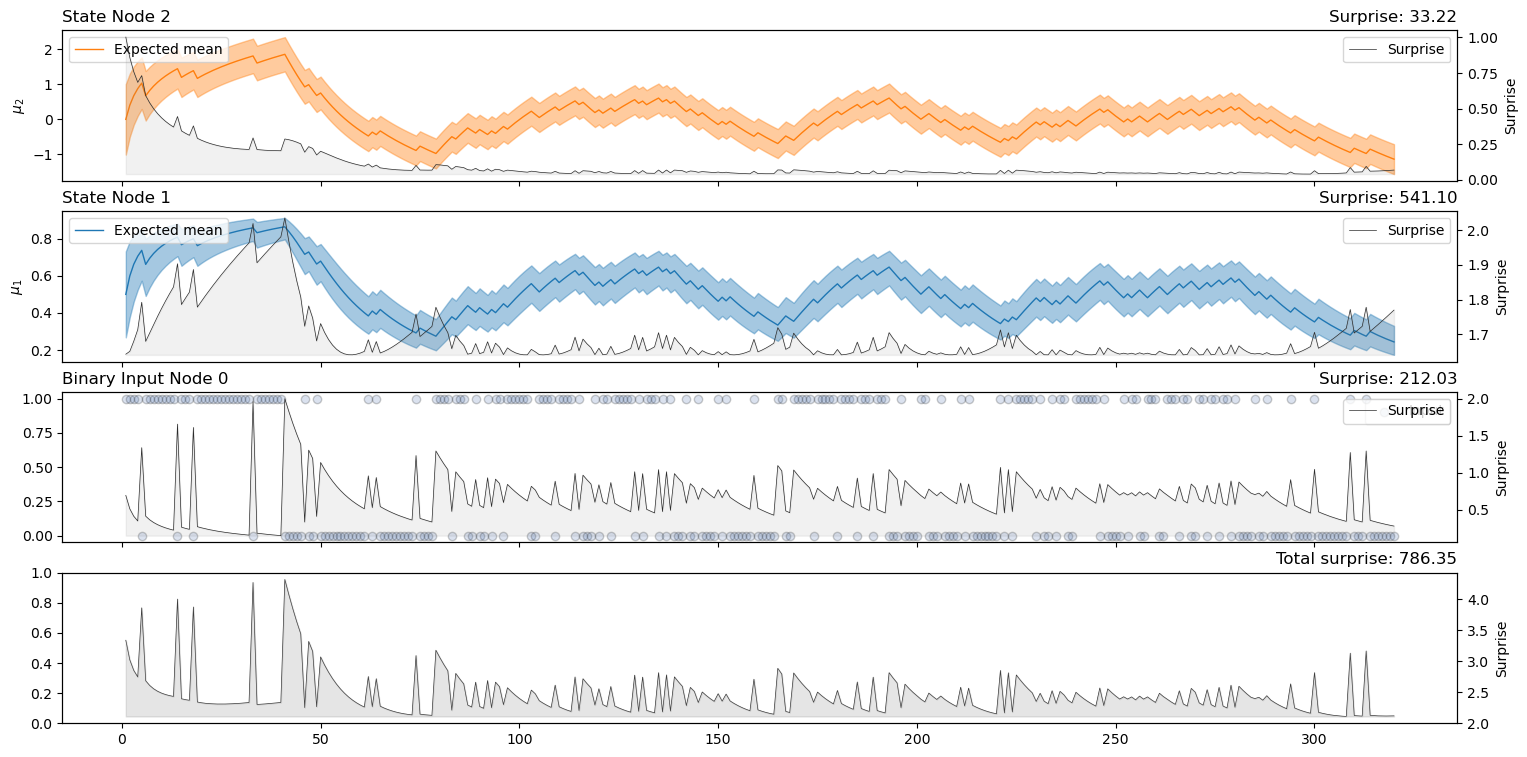

In [21]:
two_levels_hgf.plot_trajectories();

We now have a model with beliefs trajectories and we want to see how these beliefs can explain the behaviour of the participant. This is where we will use the decision vector $y$ together with a response model. Designing response models that are adapted to the task is a central part of the modelling process (you can read more on this in the {ref}`custom_response_functions` section). Here, we use the `binary_softmax`, which means that we assume the expected probability at the first level of the model predicts the decision.

In [22]:
two_levels_hgf.surprise(
    response_function=binary_softmax,  # the response model
    response_function_inputs=y         # the decision vector
)

Array(182.46234, dtype=float32)

Once we have these two piece of information, we are ready to compute the surprise, which will indicates how well our model could prediction the behavior of the participant.

```{hint}
The actions, or decisions, initiated by the agent are not influencing the way beliefs about the hidden states of the world are being updated (this is NOT active inference). This is for sure a limitation of the model, but it also means that the belief updating and the response model can be processed separately. In other words, no matter what actions the agent is taking along the way, this will not change the way sensory evidence is updating beliefs.
```

```{admonition} Exercises 5
- Using the examples above, can you diagnose the performances of the agent?
- What could make it better?
- Can you try to change the parameters and get an agent with better performances (i.e. minimizing the surprise)?
```

### Model comparison

When modelling, we always want to control for alternative, simpler explanations. It might be that our subjects are dynamically updating their beliefs in accordance with our assumptions. However, sometimes, they might just be responding rather randomly and not show much learning at all. It might also be that they are using a simple learning model that does not require to use of the HGF to capture higher-order volatility. We want to analyse the data using all these models and compare how well they can explain the participant's responses.

#### Biased random

To control for this possibility, we define the simpler alternative model below. This model just takes random actions with a single fixed probability. It does not integrate the data from the task at all. Here, we write our models using [PyTensor](https://pytensor.readthedocs.io/en/latest/), which is the tensor library on which [PyMC](https://www.pymc.io/welcome.html) is built, and sample the model the same way. We start by creating a log probability function, that measures the model error when observing the response data. Note that we do not need the observation $u$ here, as our assumption is that the agent is not using it.

In [23]:
def logp(value, action_probability):

    responses = pt.as_tensor_variable(y, dtype="int32")

    # compute the log probability associated with the actual responses
    logp = pt.sum(pt.log(pt.power(action_probability, responses) * pt.power((1 - action_probability), 1-responses)))

    return logp

In [24]:
with pm.Model() as biased_random_model:
    y_data = pm.Data("y_data", y)
    bias = pm.Beta("bias", 1.0, 1.0)  # a simple bias toward deciding 1 vs. 0
    biased_random = pm.DensityDist('biased_random', bias, logp=logp, observed=y_data)

In [25]:
with biased_random_model:
    biased_random_idata = pm.sample(chains=4, cores=1, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [bias]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


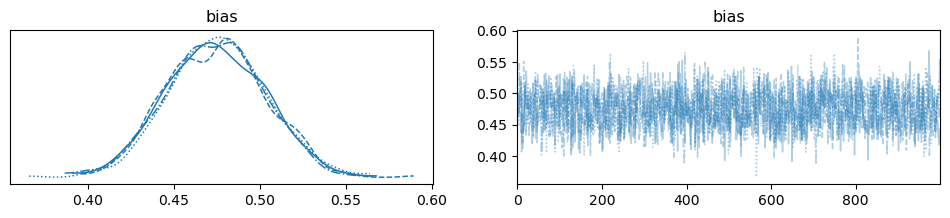

In [26]:
az.plot_trace(biased_random_idata);

Assess model fitting, here using leave-one-out cross-validation from the [Arviz](https://python.arviz.org/en/stable/api/generated/arviz.loo.html) library.

In [27]:
%%capture --no-display
az.loo(biased_random_idata)

Computed from 4000 posterior samples and 1.0 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -222.69     0.00
p_loo        0.92        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1  100.0%

#### Rescorla-Wagner

Another popular model in reinforcement learning is the [Rescorla-Wagner model](https://en.wikipedia.org/wiki/Rescorla%E2%80%93Wagner_model), which assumes that the agent uses prediction errors from the previous observation to update its beliefs. Here we create a simple Rescorla-Wagner and try to optimize the learning rate to predict the agent decisions.

In [28]:
def rw_update(new_observation, new_response, current_belief, current_action_probability, learning_rate):
    """The decision and update step at time t."""

    # pass previous belief through softmax to get action probability
    action_probability = 1 / (1 + pt.exp(-current_belief))

    # compute the error associated with the actual responses
    error = new_response * pt.log(action_probability) + (1 - new_response) * pt.log(1-action_probability)

    # sigmoid transform the previous beliefs at t-1 (into [0,1])
    transformed_old_value = 1 / (1 + pt.exp(-current_belief))

    # get the new value using the RW update
    new_belief = current_belief + learning_rate * (new_observation - transformed_old_value)

    return new_belief, error

In [29]:
def logp(value, learning_rate):
    """Compute the sum of log probabilities."""

    observations = pt.as_tensor_variable(u, dtype="int32")
    responses = pt.as_tensor_variable(y, dtype="int32")
    outputs_info = pt.as_tensor_variable(np.asarray(0.0, observations.dtype))
    curret_belief = pt.zeros(1, dtype="float")
    error = pt.zeros(1, dtype="float")
    
    results, updates = scan(
        fn=rw_update, 
        sequences=[observations, responses], 
        non_sequences=[learning_rate],
        outputs_info=[curret_belief, error]
    )

    _, error = results
    
    # compute the log probability associated with the actual responses
    logp = pt.sum(error)

    return logp

In [30]:
with pm.Model() as rw_model:
    y_data = pm.Data("y_data", y)
    lr = pm.Normal("lr", 0.0, 2.0)  # learning rate
    hgf = pm.DensityDist('hgf', lr, logp=logp, observed=y_data)

In [31]:
with rw_model:
    rw_idata = pm.sample(chains=4, cores=1, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [lr]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.


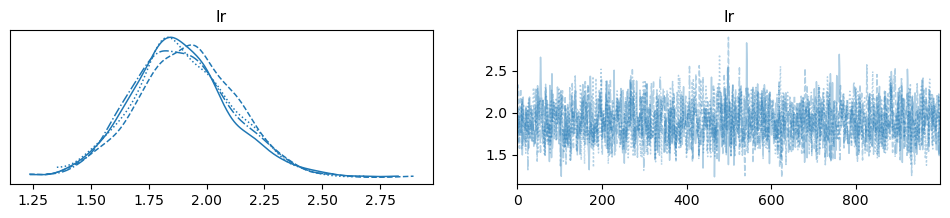

In [32]:
az.plot_trace(rw_idata);

In [33]:
%%capture --no-display
az.loo(rw_idata)

Computed from 4000 posterior samples and 1.0 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -103.99     0.00
p_loo        0.76        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1  100.0%
   (1, Inf)   (very bad)    0    0.0%

We can visualize the belief updating using this model as:

In [34]:
learning_rate = az.summary(rw_idata)["mean"].lr

def rw_update(new_observation, current_belief):

    # sigmoid transform the beliefs at t-1 (into [0,1])
    transformed_old_value = 1 / (1 + np.exp(-current_belief))

    # get the new value using the RW update
    new_belief = current_belief + learning_rate * (new_observation - transformed_old_value)

    return new_belief

beliefs = [0.0]
for i in u:
    new_belief = rw_update(i, beliefs[-1])
    beliefs.append(new_belief)
beliefs = 1 / (1 + np.exp(-np.array(beliefs)))

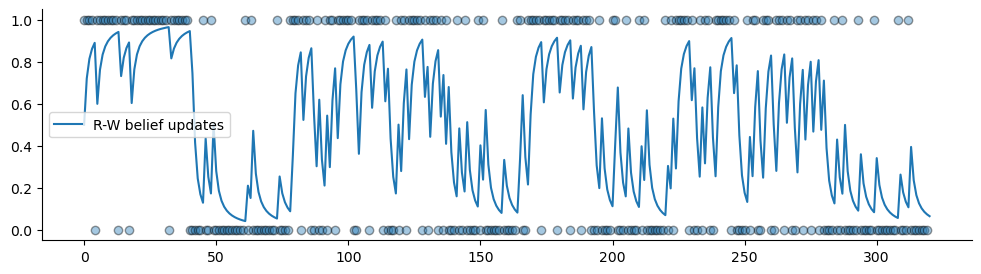

In [35]:
plt.figure(figsize=(12, 3))
plt.plot(beliefs, label="R-W belief updates")
plt.scatter(np.arange(len(u)), u, alpha=.4, edgecolor="k")
plt.legend()
sns.despine()

#### Two-level HGF

Finally, we can model the behaviour using the two-level or the three-level HGF. The two-level model should generate prediction similar to what we have with the Rescorla-Wagner model, while the three-level HGF is adding a layer of volatility and therefore could take advantage of higher-level dynamics of volatility.

In [36]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=u[np.newaxis, :],
    response_function=binary_softmax,
    response_function_inputs=y[np.newaxis, :],
)

In [37]:
def logp(value, tonic_volatility_2):
    return hgf_logp_op(tonic_volatility_2=tonic_volatility_2)

In [38]:
with pm.Model() as two_levels_binary_hgf:
    y_data = pm.Data("y_data", y)
    tonic_volatility_2 = pm.Normal("tonic_volatility_2", -5.0, 2.0)
    hgf = pm.DensityDist('hgf', tonic_volatility_2, logp=logp, observed=y_data)

In [39]:
with two_levels_binary_hgf:
    two_levels_idata = pm.sample(chains=4, cores=1, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [tonic_volatility_2]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


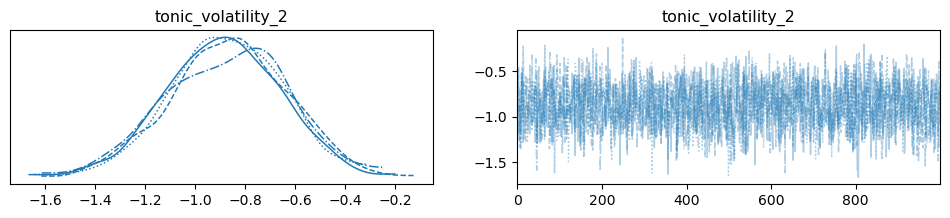

In [40]:
az.plot_trace(two_levels_idata);

In [41]:
%%capture --no-display
az.loo(two_levels_idata)

Computed from 4000 posterior samples and 1.0 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -114.05     0.00
p_loo        0.74        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1  100.0%
   (1, Inf)   (very bad)    0    0.0%

#### Three-level HGF

In [42]:
hgf_logp_op = HGFDistribution(
    n_levels=3,
    model_type="binary",
    input_data=u[np.newaxis, :],
    response_function=binary_softmax,
    response_function_inputs=y[np.newaxis, :]
)

In [43]:
def logp(value, tonic_volatility_2):
    return hgf_logp_op(
        tonic_volatility_2=tonic_volatility_2, 
        tonic_volatility_3=-6.0, 
        mean_3=1.0
    )

In [44]:
with pm.Model() as three_levels_binary_hgf:
    y_data = pm.Data("y_data", y)
    tonic_volatility_2 = pm.Normal("tonic_volatility_2", -5.0, 2.0)
    hgf = pm.DensityDist('hgf', tonic_volatility_2, logp=logp, observed=y_data)

In [45]:
with three_levels_binary_hgf:
    three_levels_idata = pm.sample(chains=4, cores=1, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [tonic_volatility_2]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


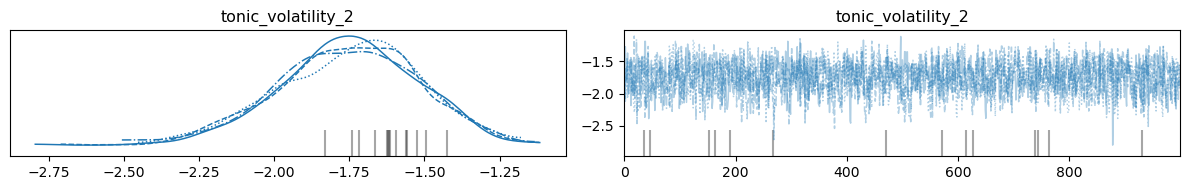

In [46]:
az.plot_trace(three_levels_idata)
plt.tight_layout();

In [47]:
%%capture --no-display
az.loo(three_levels_idata)

Computed from 4000 posterior samples and 1.0 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -113.78     0.00
p_loo        0.82        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1  100.0%
   (1, Inf)   (very bad)    0    0.0%

In [48]:
%%capture --no-display
az.compare(
    {
        "biased_random": biased_random_idata, 
        "RW": rw_idata, 
        "two-level": two_levels_idata, 
        "three-level": three_levels_idata
    }
)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
RW,0,-103.988640,0.757421,0.000000,1.000000e+00,0.0,0.0,True,log
three-level,1,-113.782138,0.815685,9.793498,3.302913e-15,0.0,0.0,True,log
two-level,2,-114.054576,0.737855,10.065936,0.000000e+00,0.0,0.0,True,log
biased_random,3,-222.688695,0.921827,118.700055,5.107026e-15,0.0,0.0,True,log


### Posterior predictive sampling

Another way to assess model fitting is to use a posterior predictive check (i.e. we want to ensure that the posterior distribution would be well suited to predict the data at hand). This is usually done by sampling from the posterior distribution and comparing it with the observations. We can do something that approaches this procedure by sampling the parameters of the HGF from the posterior distribution obtained in the previous steps and plotting the resulting trajectories. We can retrieve the parameters of the posterior distributions from our previous fit:

And use them to sample new parameters from the same distribution and plot the beliefs trajectories accordingly:

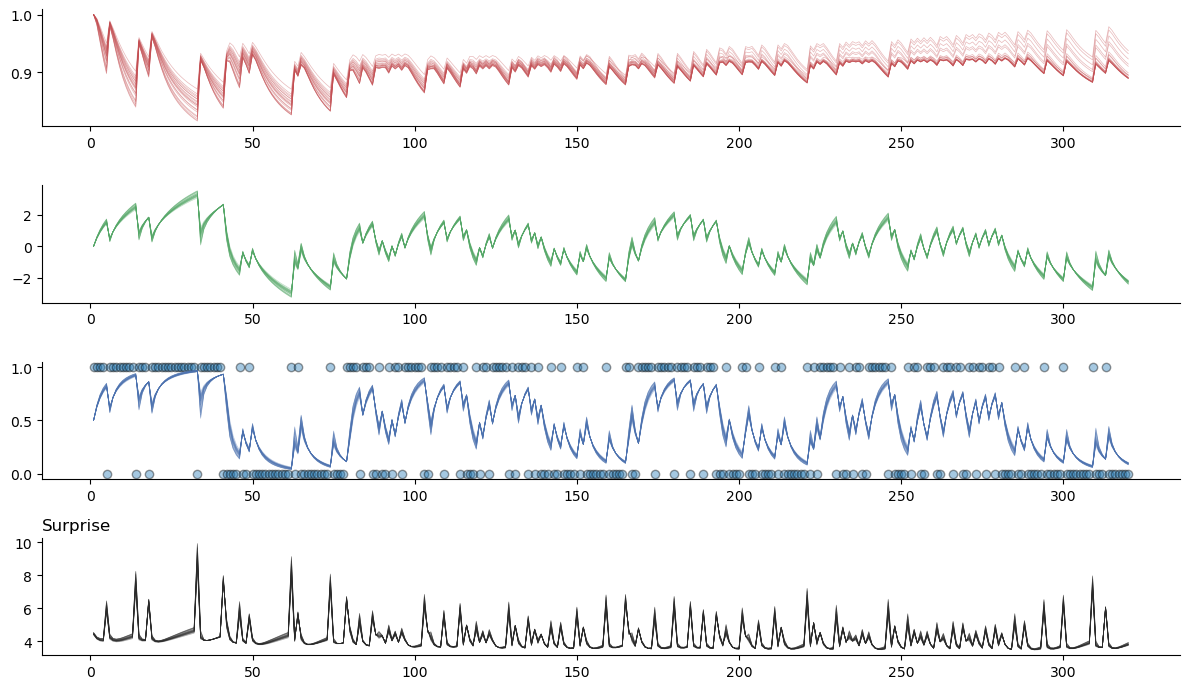

In [49]:
fig, axs = plt.subplots(nrows=4, figsize=(12, 7))

for _ in range(20):

    tonic_volatility_2 = np.random.normal(
        az.summary(three_levels_idata)["mean"].tonic_volatility_2, 
        az.summary(three_levels_idata)["sd"].tonic_volatility_2
    )
    
    three_levels_df = HGF(
        n_levels=3,
        model_type="binary",
        initial_mean={"1": .0, "2": 0.0, "3": 1.0},
        initial_precision={"1": .0, "2": 1.0, "3": 1.0},
        tonic_volatility={"2": tonic_volatility_2, "3": -6.0},
        verbose=False
    ).input_data(input_data=u).to_pandas()
    
    axs[0].plot(
        three_levels_df.time, 
        three_levels_df.x_3_expected_mean,
        alpha=.4,
        linewidth=.5,
        color="#c44e52"
    )
    
    axs[1].plot(
        three_levels_df.time, 
        three_levels_df.x_2_expected_mean,
        alpha=.4,
        linewidth=.5,
        color="#55a868"
    )
    
    axs[2].plot(
        three_levels_df.time, 
        three_levels_df.x_1_expected_mean,
        alpha=.4,
        linewidth=.5,
        color="#4c72b0"
    )


    axs[3].plot(
        three_levels_df.time, 
        three_levels_df.total_surprise,
        alpha=.4,
        linewidth=.5,
        color="#2a2a2a"
    )

axs[2].scatter(
    three_levels_df.time, 
    three_levels_df.observation_input_0,
    alpha=0.4,
    edgecolor="k"
)
axs[3].set_title("Surprise", loc="left")
plt.tight_layout()
sns.despine()

# System configuration

In [50]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Thu Jun 27 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.23.0

pyhgf : 0.1.2
jax   : 0.4.30
jaxlib: 0.4.30

sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
seaborn   : 0.13.2
numpy     : 1.26.0
jax       : 0.4.30
pytensor  : 2.23.0
matplotlib: 3.8.4
pandas    : 2.2.2
pymc      : 5.16.1
arviz     : 0.18.0

Watermark: 2.4.3

